# Experiment 04

This Experiment is the main experiment of the work, consists in run an optimized Random Forest in order to try to predict the values in question.(https://www.researchgate.net/publication/221533996_From_an_artificial_neural_network_to_a_stock_market_day-trading_system_A_case_study_on_the_BMF_BOVESPA).

This method consists in using the sliding window 

In [1]:
import numpy as np
import pandas as pd

import Utils 
from Utils import calculateEMA, calculateBB, addPreviousDays, removeColumns, getPeriod, mape, mae, createDate, getDate, printResult

import matplotlib.pyplot as plt
import matplotlib.dates as mpdates
import mplfinance as mpf
from mplfinance.original_flavor import candlestick_ohlc

import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestRegressor

### Constants and Parameters

In [2]:
dfColumns = ['date','open', 'high', 'low','close','tickvol','volume','spread']
newColumns = ['open', 'high', 'low', 'close']
col15 = ['open','d-5_high','d-5_low','d-4_high','d-4_low','d-3_high','d-3_low','d-2_high','d-2_low','d-1_high','d-1_low','EMA_high','EMA_low','UB_close','LB_close']
col25 = ['open','d-5_open','d-5_high','d-5_low','d-5_close','d-4_open','d-4_high','d-4_low','d-4_close','d-3_open','d-3_high','d-3_low','d-3_close','d-2_open','d-2_high','d-2_low','d-2_close','d-1_open','d-1_high','d-1_low','d-1_close','EMA_high' ,'EMA_low','UB_close','LB_close']

top10_petr4 = ['LB_low', 'd-1_high', 'LB_close', 'LB_open', 'EMA_high', 'd-1_low','EMA_low', 'd-1_close', 'EMA_close', 'open']
top5_petr4 = ['d-1_low','EMA_low', 'd-1_close', 'EMA_close', 'open']
top3_petr4 = ['d-1_close', 'EMA_close', 'open']

top10_vale3 = ['d-1_high', 'd-1_low', 'UB_high', 'UB_low', 'UB_close', 'EMA_low','UB_open', 'd-1_close', 'EMA_close', 'open']
top5_vale3 = ['EMA_low','UB_open', 'd-1_close', 'EMA_close', 'open']
top3_vale3 = ['d-1_close', 'EMA_close', 'open']

DAYS = 5

In [3]:
TEST_BEGIN = '2020.06.01'
TEST_END = '2021.06.01'

WINDOW = 700
DRIFT = 10

TIMES = 1

def safeDate(df, begin, period):
    index = df[df['date'] == begin].index[0]
    
    newIndex = index - (period + 2)
    newDate = df[df.index == newIndex].date
    
    return newDate.iloc[0]

### Opening the dataset

In [4]:
df = pd.read_csv('../Data/PETR4_Daily.csv', sep = "\t")
df.columns = dfColumns
df = removeColumns(df, ['tickvol', 'volume','spread'])

beginDate = safeDate(df, TEST_BEGIN, WINDOW)

df2 = pd.read_csv('../Data/VALE3_Daily.csv', sep = "\t")
df2.columns = dfColumns
df2 = removeColumns(df2, ['tickvol', 'volume','spread'])

In [5]:
#PETR4
df = calculateEMA(df,DAYS,newColumns)
df = calculateBB(df,DAYS,newColumns)
df = addPreviousDays(df,DAYS, newColumns)

#VALE3
df2 = calculateEMA(df2,DAYS,newColumns)
df2 = calculateBB(df2,DAYS,newColumns)
df2 = addPreviousDays(df2,DAYS, newColumns)

In [6]:
initialDf_PETR4 = getPeriod(df, beginDate ,TEST_END, True)
initialDf_VALE3 = getPeriod(df2,beginDate,TEST_END, True)

In [7]:
initialDf_PETR4

,date,open,high,low,close,EMA_open,EMA_high,EMA_low,EMA_close,UB_open,...,d-3_low,d-3_close,d-4_open,d-4_high,d-4_low,d-4_close,d-5_open,d-5_high,d-5_low,d-5_close
0,2017.07.25,11.80,12.02,11.80,11.99,11.767548,11.898038,11.668546,11.794237,12.109500,...,11.82,11.88,11.79,12.04,11.76,12.00,11.79,11.81,11.64,11.74
1,2017.07.26,12.06,12.10,11.77,11.77,11.865032,11.965359,11.702364,11.786158,12.232253,...,11.49,11.51,12.05,12.11,11.82,11.88,11.79,12.04,11.76,12.00
2,2017.07.27,11.84,11.94,11.79,11.79,11.856688,11.956906,11.731576,11.787439,12.128523,...,11.58,11.68,11.79,11.83,11.49,11.51,12.05,12.11,11.82,11.88
3,2017.07.28,11.77,11.91,11.71,11.91,11.827792,11.941271,11.724384,11.828293,12.127418,...,11.80,11.99,11.64,11.72,11.58,11.68,11.79,11.83,11.49,11.51
4,2017.07.31,11.99,12.07,11.85,12.05,11.881861,11.984180,11.766256,11.902195,12.144745,...,11.77,11.77,11.80,12.02,11.80,11.99,11.64,11.72,11.58,11.68
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
946,2021.05.26,25.91,26.18,25.65,26.09,26.114791,26.354219,25.760657,26.042263,26.608719,...,25.94,25.95,26.15,26.28,25.72,25.93,25.85,26.35,25.80,26.15
947,2021.05.27,26.08,26.25,25.77,25.91,26.103194,26.319479,25.763771,25.998175,26.604087,...,25.99,26.39,26.08,26.31,25.94,25.95,26.15,26.28,25.72,25.93
948,2021.05.28,26.20,27.02,26.15,26.99,26.135462,26.552986,25.892514,26.328784,26.617551,...,25.78,25.84,26.28,26.52,25.99,26.39,26.08,26.31,25.94,25.95
949,2021.05.31,26.96,27.20,26.78,26.87,26.410308,26.768657,26.188343,26.509189,27.147657,...,25.65,26.09,26.48,26.62,25.78,25.84,26.28,26.52,25.99,26.39


In [8]:
initialDf_VALE3

,date,open,high,low,close,EMA_open,EMA_high,EMA_low,EMA_close,UB_open,...,d-3_low,d-3_close,d-4_open,d-4_high,d-4_low,d-4_close,d-5_open,d-5_high,d-5_low,d-5_close
0,2017.07.25,25.86,26.82,25.86,26.78,25.642986,26.149633,25.407715,25.909778,26.805159,...,25.07,25.13,26.26,26.40,26.01,26.16,26.16,26.28,25.83,26.16
1,2017.07.26,27.04,27.04,25.94,25.95,26.108657,26.446422,25.585143,25.923185,27.467193,...,24.78,24.94,26.10,26.10,25.07,25.13,26.26,26.40,26.01,26.16
2,2017.07.27,25.95,26.43,25.61,25.99,26.055772,26.440948,25.593429,25.945457,27.417838,...,24.94,25.49,25.11,25.41,24.78,24.94,26.10,26.10,25.07,25.13
3,2017.07.28,25.84,26.56,25.66,26.55,25.983848,26.480632,25.615619,26.146971,27.372997,...,25.86,26.78,25.04,25.51,24.94,25.49,25.11,25.41,24.78,24.94
4,2017.07.31,27.56,27.58,27.16,27.39,26.509232,26.847088,26.130413,26.561314,28.046997,...,25.94,25.95,25.86,26.82,25.86,26.78,25.04,25.51,24.94,25.49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
946,2021.05.26,106.37,110.32,106.03,110.20,109.166674,111.131617,107.622606,109.807900,113.973861,...,108.50,109.40,111.70,112.10,110.20,111.11,112.10,112.78,109.84,112.25
947,2021.05.27,110.80,112.09,109.77,110.99,109.711116,111.451078,108.338404,110.201933,113.405981,...,107.51,109.78,111.11,111.25,108.50,109.40,111.70,112.10,110.20,111.11
948,2021.05.28,111.11,112.75,109.42,111.59,110.177411,111.884052,108.698936,110.664622,113.405981,...,106.78,107.05,108.00,110.14,107.51,109.78,111.11,111.25,108.50,109.40
949,2021.05.31,112.50,114.89,112.50,114.78,110.951607,112.886035,109.965957,112.036415,114.811204,...,106.03,110.20,110.28,110.89,106.78,107.05,108.00,110.14,107.51,109.78


#### Experimento 04: Utilizando Random Forest

In [62]:
def getTrainPeriod(df, begin, period):
    
    index = df[df['date'] == begin].index[0]
    index = index-1
    
    endDate = df[df.index == index].date
    beginDate = df[df.index == (index-period)].date
    
    return beginDate.iloc[0], endDate.iloc[0]
    

def exp04(df, stock, inputColumns = []):
    
    beginTrain, endTrain = getTrainPeriod(df,TEST_BEGIN, WINDOW)
    
    df_test_aux = getPeriod(df, TEST_BEGIN, TEST_END)
    
    indexBegin = df_test_aux.head(1).index[0]
    indexEnd = df_test_aux.tail(1).index[0]
    
    for i in range (indexBegin, indexEnd, DRIFT):
        
        df_test = df[(df.index >= i) & (df.index <= i+DRIFT-1)]
        df_train = df[(df.index >= i-WINDOW) & (df.index < i)]
    
        if(inputColumns == []):
            x_train = df_train.drop(['date', 'high', 'low', 'close'], axis=1)
            y_train = df_train[['high','low']]

            x_test = df_test.drop(['date', 'high', 'low', 'close'], axis=1)
            y_test = df_test[['high','low']]
        else:
            x_train = df_train[inputColumns]
            y_train = df_train[['high','low']]

            x_test = df_test[inputColumns]
            y_test = df_test[['high','low']]

        rf = RandomForestRegressor(n_estimators = 500)
        rf.fit(x_train, y_train);
        y_pred = rf.predict(x_test)
        
        print('train: ' + df_train['date'].head(1).tolist()[0] + ' - ' + df_train['date'].tail(1).tolist()[0])
        print('_test: ' + df_test['date'].head(1).tolist()[0] + ' - ' + df_test['date'].tail(1).tolist()[0])
        #printResult(mape(y_test['high'],y_pred[:,0]), 'High')
        #printResult(mape(y_test['low'],y_pred[:,1]), 'Low')
        #print('###')
        
        if(i == indexBegin):     
            predDf = y_test.copy()
            predDf['high_pred'] = y_pred[:,0]
            predDf['low_pred'] = y_pred[:,1]
        
        else:
            auxDf = y_test.copy()
            auxDf['high_pred'] = y_pred[:,0]
            auxDf['low_pred'] = y_pred[:,1]
            predDf = predDf.append(auxDf)
        
        #errorMax = mape(predDf['high'],predDf['high_pred'])
        #errorMin = mape(predDf['low'],predDf['low_pred'])
    
    return predDf

def test30timesExp04(df,stock, phrase, columnInput = []):

    acc_predDf = pd.DataFrame()
    
    for i in range(1, TIMES+1):
        if(columnInput == []):
            predDf = exp04(df, stock)
        else: 
            predDf = exp04(df, stock, columnInput)
        
        acc_predDf = acc_predDf.append(predDf)
        
    print(phrase)
    printResult(mape(acc_predDf['high'],acc_predDf['high_pred']), 'High')
    printResult(mape(acc_predDf['low'],acc_predDf['low_pred']), 'Low')
    
    return acc_predDf

In [12]:
exec01 = test30timesExp04(initialDf_PETR4, 'PETR4', 'PETR4 TOP 3 Variables', top3_petr4)
exec02 = test30timesExp04(initialDf_PETR4, 'PETR4', 'PETR4 TOP 5 Variables', top5_petr4) 
exec03 = test30timesExp04(initialDf_PETR4, 'PETR4', 'PETR4 TOP 10 Variables', top10_petr4) 
exec04 = test30timesExp04(initialDf_PETR4, 'PETR4', 'PETR4 15 Variables', col15) 
exec05 = test30timesExp04(initialDf_PETR4, 'PETR4', 'PETR4 25 Variables', col25) 
exec06 = test30timesExp04(initialDf_PETR4, 'PETR4', 'PETR4 33 Variables') 
print('\n')
exec07 = test30timesExp04(initialDf_VALE3, 'VALE3', 'VALE3 TOP 3 Variables', top3_vale3)
exec08 = test30timesExp04(initialDf_VALE3, 'VALE3', 'VALE3 TOP 5 Variables', top5_vale3) 
exec09 = test30timesExp04(initialDf_VALE3, 'VALE3', 'VALE3 TOP 10 Variables', top10_vale3)
exec10 = test30timesExp04(initialDf_VALE3, 'VALE3', 'VALE3 15 Variables', col15)
exec11 = test30timesExp04(initialDf_VALE3, 'VALE3', 'VALE3 25 Variables', col25)
exec12 = test30timesExp04(initialDf_VALE3, 'VALE3', 'VALE3 33 Variables')

PETR4 TOP 3 Variables
High: 1.12 +- 1.01 %
Low: 1.07 +- 0.96 %
PETR4 TOP 5 Variables
High: 1.09 +- 0.99 %
Low: 1.07 +- 0.96 %
PETR4 TOP 10 Variables
High: 1.09 +- 0.94 %
Low: 1.05 +- 0.9 %
PETR4 15 Variables
High: 1.04 +- 0.89 %
Low: 1.01 +- 0.89 %
PETR4 25 Variables
High: 1.05 +- 0.9 %
Low: 1.02 +- 0.91 %
PETR4 33 Variables
High: 1.03 +- 0.9 %
Low: 1.01 +- 0.92 %


VALE3 TOP 3 Variables
High: 2.07 +- 2.73 %
Low: 2.07 +- 2.58 %
VALE3 TOP 5 Variables
High: 2.12 +- 2.71 %
Low: 2.12 +- 2.55 %
VALE3 TOP 10 Variables
High: 2.11 +- 2.68 %
Low: 2.18 +- 2.53 %
VALE3 15 Variables
High: 2.24 +- 2.79 %
Low: 2.35 +- 2.68 %
VALE3 25 Variables
High: 2.28 +- 2.79 %
Low: 2.39 +- 2.69 %
VALE3 33 Variables
High: 2.29 +- 2.75 %
Low: 2.39 +- 2.66 %


In [13]:
DRIFT = 1
exec13 = test30timesExp04(initialDf_VALE3, 'VALE3', 'VALE3 TOP 3 Variables', top3_vale3)
exec14 = test30timesExp04(initialDf_VALE3, 'VALE3', 'VALE3 TOP 5 Variables', top5_vale3) 
exec15 = test30timesExp04(initialDf_VALE3, 'VALE3', 'VALE3 TOP 10 Variables', top10_vale3)
exec16 = test30timesExp04(initialDf_VALE3, 'VALE3', 'VALE3 15 Variables', col15)
exec17 = test30timesExp04(initialDf_VALE3, 'VALE3', 'VALE3 25 Variables', col25)
exec18 = test30timesExp04(initialDf_VALE3, 'VALE3', 'VALE3 33 Variables')

VALE3 TOP 3 Variables
High: 1.17 +- 1.15 %
Low: 1.16 +- 0.98 %
VALE3 TOP 5 Variables
High: 1.19 +- 1.17 %
Low: 1.18 +- 0.99 %
VALE3 TOP 10 Variables
High: 1.2 +- 1.14 %
Low: 1.22 +- 0.99 %
VALE3 15 Variables
High: 1.25 +- 1.22 %
Low: 1.31 +- 1.09 %
VALE3 25 Variables
High: 1.29 +- 1.28 %
Low: 1.34 +- 1.13 %
VALE3 33 Variables
High: 1.28 +- 1.24 %
Low: 1.33 +- 1.1 %


In [14]:
DRIFT = 5
exec01 = test30timesExp04(initialDf_PETR4, 'PETR4', 'PETR4 TOP 3 Variables', top3_petr4)
exec02 = test30timesExp04(initialDf_PETR4, 'PETR4', 'PETR4 TOP 5 Variables', top5_petr4) 
exec03 = test30timesExp04(initialDf_PETR4, 'PETR4', 'PETR4 TOP 10 Variables', top10_petr4) 
exec04 = test30timesExp04(initialDf_PETR4, 'PETR4', 'PETR4 15 Variables', col15) 
exec05 = test30timesExp04(initialDf_PETR4, 'PETR4', 'PETR4 25 Variables', col25) 
exec06 = test30timesExp04(initialDf_PETR4, 'PETR4', 'PETR4 33 Variables') 
print('\n')

PETR4 TOP 3 Variables
High: 1.1 +- 0.98 %
Low: 1.05 +- 0.95 %
PETR4 TOP 5 Variables
High: 1.07 +- 0.95 %
Low: 1.05 +- 0.95 %
PETR4 TOP 10 Variables
High: 1.06 +- 0.94 %
Low: 1.04 +- 0.89 %
PETR4 15 Variables
High: 1.03 +- 0.9 %
Low: 1.01 +- 0.9 %
PETR4 25 Variables
High: 1.04 +- 0.9 %
Low: 1.01 +- 0.91 %
PETR4 33 Variables
High: 1.01 +- 0.89 %
Low: 1.0 +- 0.9 %




In [55]:
predDf_petr4 = exec03
predDf_vale3 = exec15
predDf_petr4['date'] = getPeriod(initialDf_PETR4, TEST_BEGIN, TEST_END)['date']
predDf_vale3['date'] = getPeriod(initialDf_PETR4, TEST_BEGIN, TEST_END)['date']

display(predDf_petr4.head(10))
predDf_petr4.to_pickle('../Data/PETR4_Pred_ytd_RF.pkl')
display(predDf_vale3.head(10))
predDf_vale3.to_pickle('../Data/VALE3_Pred_ytd_RF.pkl')

,high,low,high_pred,low_pred,date
702,19.89,19.35,19.92820,19.36218,2020.06.01
703,20.70,19.93,20.29546,19.72336,2020.06.02
704,21.20,20.71,22.13276,20.98760,2020.06.03
705,21.07,20.36,20.99832,20.45796,2020.06.04
706,22.28,21.34,22.14836,21.00934,2020.06.05
707,21.86,21.29,22.20718,21.13986,2020.06.08
708,21.32,20.94,21.97440,21.05076,2020.06.09
709,21.19,20.32,21.84592,20.96758,2020.06.10
710,20.48,19.45,20.37174,19.74398,2020.06.12
711,20.40,18.91,19.78546,19.01174,2020.06.15


,high,low,high_pred,low_pred,date
702,50.40,49.14,49.91982,48.72682,2020.06.01
703,50.35,49.60,50.73920,49.24922,2020.06.02
704,50.86,49.96,51.06704,49.87950,2020.06.03
705,52.13,50.09,51.15260,49.90818,2020.06.04
706,53.07,50.86,53.40794,52.04738,2020.06.05
707,52.08,50.52,51.83162,50.21864,2020.06.08
708,51.47,50.65,51.68660,50.18364,2020.06.09
709,51.66,50.31,51.71858,50.43242,2020.06.10
710,50.59,48.65,51.46022,50.00840,2020.06.12
711,50.94,48.79,50.04816,48.63832,2020.06.15


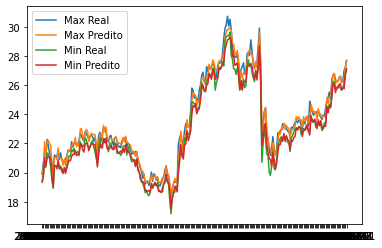

In [56]:
plottingdf = predDf_petr4
plt.plot(plottingdf['date'], plottingdf['high'], label = "Max Real")
plt.plot(plottingdf['date'], plottingdf['high_pred'], label = "Max Predito")
plt.plot(plottingdf['date'], plottingdf['low'], label = "Min Real")
plt.plot(plottingdf['date'], plottingdf['low_pred'], label = "Min Predito")
plt.legend()
plt.show()

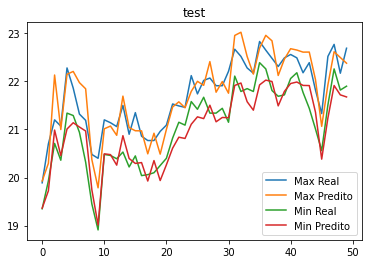

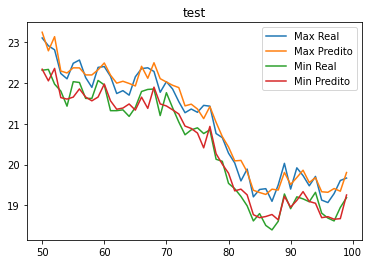

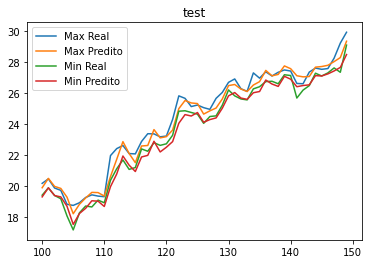

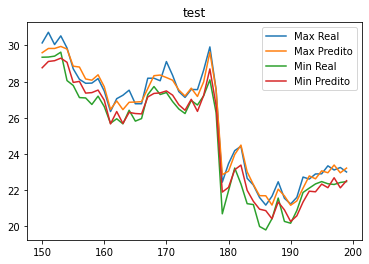

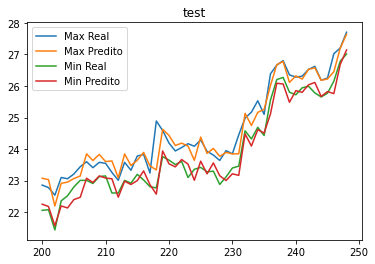

In [61]:
dfs = {}
chunk = 50

df = plottingdf.reset_index()

for n in range((df.shape[0] // chunk + 1)):
    df_temp = df.iloc[n*chunk:(n+1)*chunk]
    #df_temp = df_temp.reset_index(drop=True)
    dfs[n] = df_temp

if df.shape[0] % chunk != 0:
    df_temp = df.iloc[-int(df.shape[0] % chunk):]
    #df_temp = df_temp.reset_index(drop=True)
    dfs[n] = df_temp
else:
    pass

for i in range(0,len(dfs)):
    plt.plot(dfs[i].index, dfs[i]['high'], label = "Max Real")
    plt.plot(dfs[i].index, dfs[i]['high_pred'], label = "Max Predito")
    plt.plot(dfs[i].index, dfs[i]['low'], label = "Min Real")
    plt.plot(dfs[i].index, dfs[i]['low_pred'], label = "Min Predito")
    plt.legend()
    plt.show()
    plt.clf